In [182]:

import seaborn as sns
import pandas as pd
import numpy as np

In [1]:
from flask_app.db.data import DataReader
import matplotlib.pyplot as plt

x_test = DataReader.execute_export_db("finance_test_x")
predict_28 = DataReader.execute_export_db("predict_28")
predict_21 = DataReader.execute_export_db("predict_21")
predict_14 = DataReader.execute_export_db("predict_14")
predict_7 = DataReader.execute_export_db("predict_7")
predict_3 = DataReader.execute_export_db("predict_3")

pred = [predict_3, predict_7, predict_14, predict_21, predict_28]

In [120]:
def post_processing(df, criteria='2022-02-01', dropout= False):
    t = df[df.index >= criteria]
    t = t / t.iloc[0] * 100
    if dropout: 
        t.drop(index=["2022-10-29"], inplace=True)
    return t

In [114]:
true_y_ratio = post_processing(x_test[DataReader.target_list_name])

In [85]:
_true_y_ratio = true_y_ratio.copy()
_true_y_ratio['equal'] = true_y_ratio.mean(axis=1)

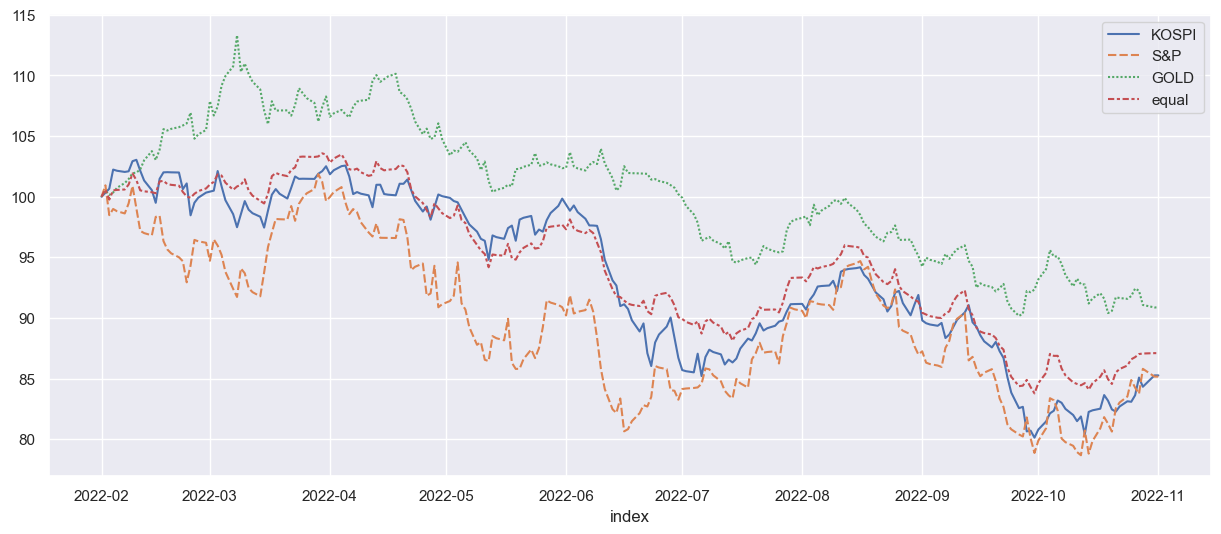

In [87]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.lineplot(_true_y_ratio);

In [121]:
ratio = []

for prediction in pred:
    ratio.append(post_processing(prediction, dropout=True))

In [167]:
def get_weights(y_pred_, y_true_, days_between):
    y_pred = y_pred_.copy()
    y_true = y_true_.copy()
    y_true.columns = y_pred.columns

    real_weight = pd.DataFrame(index=y_pred.index, columns = y_pred.columns, dtype=float)
    real_weight.iloc[0] = [0.33,.33,.33]
    
    weight = real_weight.copy()
    # weight.iloc[0] = [0.33,0.33,.33]
    
    for i in range(1, len(real_weight.index), days_between):
        weight.iloc[:i].fillna(method='ffill', inplace=True)
        real_weight.iloc[:i].fillna(method='ffill', inplace=True)
        result = y_pred.iloc[i] - y_true.iloc[i]
        if (result**2).sum() == 0:
            real_weight.iloc[i] = real_weight.iloc[i-1]
            weight.iloc[i] = weight.iloc[i-1]
        else:
            asset_total = (y_true.iloc[i]*weight.iloc[i-1]).sum() # sell all asset
            predict_norm = y_pred.iloc[i]/(y_pred.iloc[i].sum())
            weight.iloc[i] = predict_norm
            real_weight.iloc[i] = predict_norm * asset_total / 100  
    weight.fillna(method='ffill', inplace=True)
    real_weight.fillna(method='ffill', inplace=True)

    return weight, real_weight

In [ ]:
def get_weights_v2(y_pred_, y_true_, days_between):
    y_pred = y_pred_.copy()
    y_true = y_true_.copy()
    y_true.columns = y_pred.columns

    real_weight = pd.DataFrame(index=y_pred.index, columns = y_pred.columns, dtype=float)
    real_weight.iloc[0] = [0.33,.33,.33]
    
    weight = real_weight.copy()
    
    for i in range(1, len(real_weight.index), days_between):
        weight.iloc[:i].fillna(method='ffill', inplace=True)
        real_weight.iloc[:i].fillna(method='ffill', inplace=True)
        result = y_pred.iloc[i] - y_true.iloc[i]
        if (result**2).sum() == 0:
            real_weight.iloc[i] = real_weight.iloc[i-1]
            weight.iloc[i] = weight.iloc[i-1]
        else:
            asset_total = (y_true.iloc[i]*weight.iloc[i-1]).sum() # sell all asset
            predict_norm = np.exp(y_pred.iloc[i])/(np.exp(y_pred.iloc[i]).sum())
            weight.iloc[i] = predict_norm
            real_weight.iloc[i] = predict_norm * asset_total / 100  
    weight.fillna(method='ffill', inplace=True)
    real_weight.fillna(method='ffill', inplace=True)

    return weight, real_weight

In [168]:
weights = []
for y_pred, date in zip(ratio, [3,7,14,21,28]):
    weight, real_weight = get_weights(y_pred, true_y_ratio, date)
    weights.append([weight, real_weight])


C:\Users\pokem\AppData\Local\Temp\ipykernel_18276\968892867.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight.iloc[:i].fillna(method='ffill', inplace=True)
C:\Users\pokem\AppData\Local\Temp\ipykernel_18276\968892867.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_weight.iloc[:i].fillna(method='ffill', inplace=True)


In [170]:
y_true = true_y_ratio.copy()

In [178]:
results = []
for weight, name in zip(weights, [3,7,14,21,28]):
    weight[1].columns = y_true.columns
    result = (y_true*weight[1]).sum(axis=1).rename(f"result_{name}")
    results.append(result)
    _true_y_ratio = pd.concat([_true_y_ratio, result], axis=1)

In [177]:
_y_true = y_true.copy()

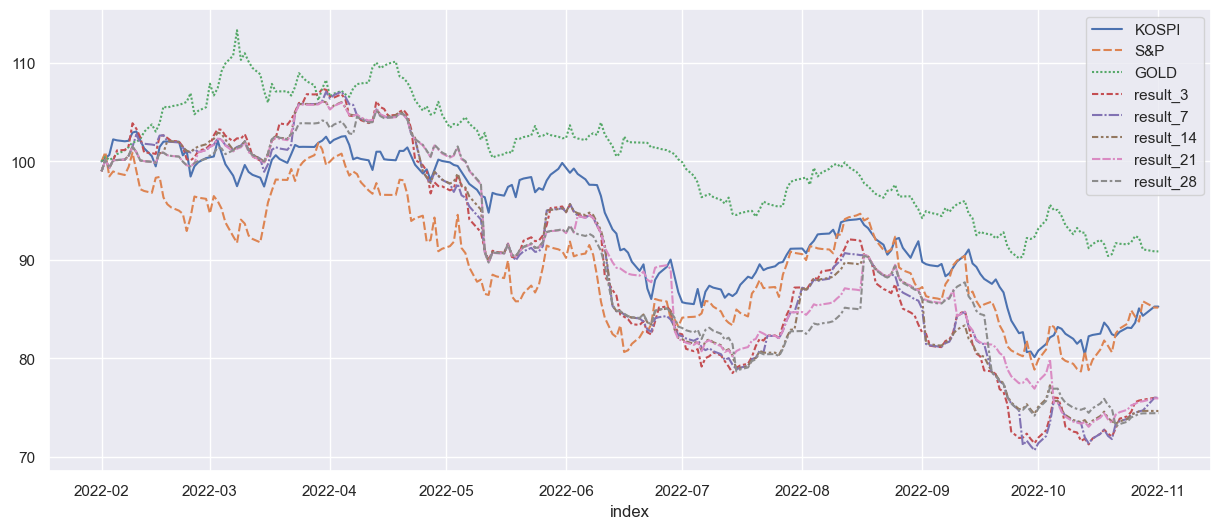

In [179]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.lineplot(_true_y_ratio);

In [180]:
DataReader.execute_import_df(_true_y_ratio, "model_results")

234